In [1]:
import numpy as np

def roll_relocation_die(origin, reloc_probs):
    """
    Draw a relocation ward for a blocked arrival from `origin`.

    Parameters
    ----------
    origin : str
        The ward that is currently full (e.g. 'A', 'B', …).
    reloc_probs : dict
        Relocation-probability matrix exactly as you defined it.

    Returns
    -------
    dest : str
        Ward to which the patient should be redirected.
    """
    row = reloc_probs[origin]                 # e.g. {'A':0.0, 'B':0.05, …}
    dests   = [w for w, p in row.items() if p > 0]   # remove zero-prob self entry
    weights = [row[w] for w in dests]
    probs   = np.array(weights) / sum(weights)        # normalise (just in case)
    return np.random.choice(dests, p=probs)









import numpy as np

np.random.seed(0)
capacities = {'A': 55, 'B': 40, 'C': 30, 'D': 20, 'E': 20}
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0}
mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9}
reloc_probs = {
    'A': {'A': 0.0, 'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.2, 'B': 0.0, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.3, 'B': 0.2, 'C': 0.0, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35,'B': 0.3, 'C': 0.05, 'D': 0.0, 'E': 0.30},
    'E': {'A': 0.2, 'B': 0.1, 'C': 0.60, 'D': 0.1, 'E': 0.0}
}

actual_time = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
actual_capacities= {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
patients_log= {'A': [], 'B': [], 'C': [], 'D': [], 'E': []}

departure_times= {'A': [], 'B': [], 'C': [], 'D': [], 'E': []}

occupancy_log = []  # (event‑time, ward, +1 for admission / –1 for discharge)

#initial kick
blocked_log=[]
for capacity in actual_capacities.keys():
            actual_time[capacity]+=np.random.exponential(scale=1/arrival_rates[capacity])
            
next_patient_to_arrive = min(actual_time, key=actual_time.get)            
departure_times[next_patient_to_arrive].append(actual_time[next_patient_to_arrive]+np.random.exponential(scale=1/mean_stays[next_patient_to_arrive]))            



while any(days < 365 for days in actual_time.values()):
         

        next_patient_to_arrive = min(actual_time, key=actual_time.get)
        all_departures_generator = (
        (time, ward) 
        for ward, times_list in departure_times.items() 
        for time in times_list
        )
        # Use min() to find the pair with the smallest time.
        # The `default` handles the case where there are no departures scheduled.
        
        earliest_departure_time, ward_to_depart = min(all_departures_generator, default=(float('inf'), None))
    

        if actual_time[next_patient_to_arrive] < earliest_departure_time:
            if actual_capacities[next_patient_to_arrive] < capacities[next_patient_to_arrive]:
                actual_capacities[next_patient_to_arrive]+=1
                occupancy_log.append((actual_time[next_patient_to_arrive], next_patient_to_arrive, +1))
                # patient_stay=actual_time[next_patient_to_arrive]+np.random.exponential(scale=1/mean_stays[next_patient_to_arrive])
                departure_times[next_patient_to_arrive].append(actual_time[next_patient_to_arrive]+np.random.exponential(scale=mean_stays[next_patient_to_arrive]))            
                # patients_log[next_patient_to_arrive].append([actual_time[next_patient_to_arrive],actual_capacities[next_patient_to_arrive],patient_stay])
                actual_time[next_patient_to_arrive]+=np.random.exponential(scale=1/arrival_rates[next_patient_to_arrive])
            else:
            
                new_ward = roll_relocation_die(next_patient_to_arrive, reloc_probs)

                if actual_capacities[new_ward] < capacities[new_ward]:
                       actual_capacities[new_ward] += 1
                       occupancy_log.append((actual_time[next_patient_to_arrive], new_ward, +1))
                       dep_time = actual_time[next_patient_to_arrive] + np.random.exponential(
                       scale=mean_stays[new_ward])
                       departure_times[new_ward].append(dep_time)
                       # always schedule the next arrival for the origin ward
                       actual_time[next_patient_to_arrive] += np.random.exponential(
                           scale=1/arrival_rates[next_patient_to_arrive])
                else:
                    blocked_log.append(actual_time[next_patient_to_arrive])        
                    # even when blocked, schedule the ward’s next arrival
                    actual_time[next_patient_to_arrive] += np.random.exponential(
                        scale=1/arrival_rates[next_patient_to_arrive])
        else: 
                    actual_capacities[ward_to_depart] = actual_capacities[ward_to_depart]-1
                    occupancy_log.append((earliest_departure_time, ward_to_depart, -1))
                    departure_times[ward_to_depart].remove(earliest_departure_time)

blocked patients          : 518
blocking rate (per day)   :   1.4192


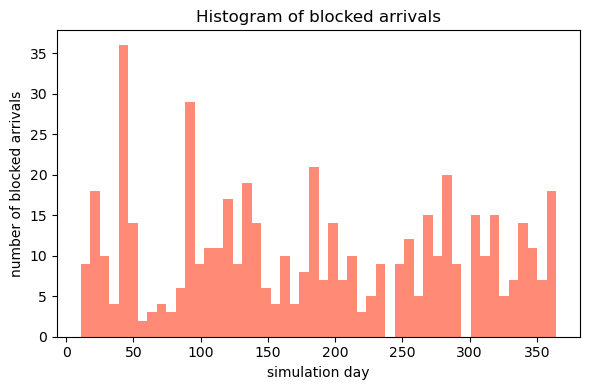

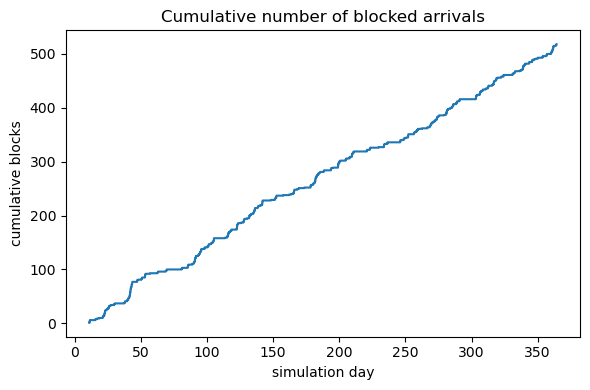

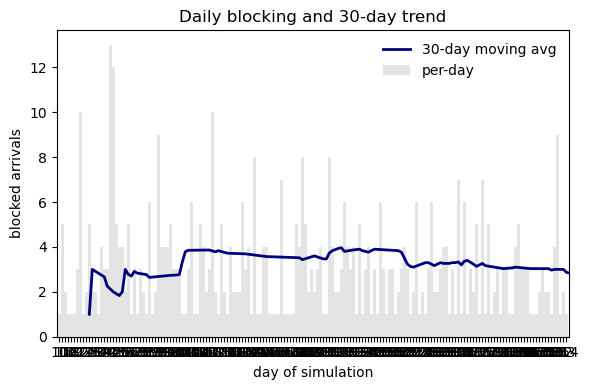

In [2]:
# -------------------------------------------------
# Quick statistics & plots for the list blocked_log
# -------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. basic counts ------------------------------------------------------------
block_times = np.asarray(blocked_log)          # numpy array for convenience
n_blocked   = len(block_times)
sim_horizon = 365                              # or 10_000 – match your run
print(f"blocked patients          : {n_blocked}")
print(f"blocking rate (per day)   : {n_blocked / sim_horizon:8.4f}")

# 2. histogram of when blocks occurred --------------------------------------
plt.figure(figsize=(6,4))
plt.hist(block_times, bins=50, color='tomato', alpha=.75)
plt.xlabel("simulation day")
plt.ylabel("number of blocked arrivals")
plt.title("Histogram of blocked arrivals")
plt.tight_layout()
plt.show()

# 3. cumulative curve --------------------------------------------------------
plt.figure(figsize=(6,4))
plt.step(np.sort(block_times), 1+np.arange(n_blocked), where="post")
plt.xlabel("simulation day")
plt.ylabel("cumulative blocks")
plt.title("Cumulative number of blocked arrivals")
plt.tight_layout()
plt.show()

# 4. (optional) daily blocking counts & 30-day moving average ---------------
# convert to a Pandas Series so we can resample by integer day
daily = pd.Series(1, index=block_times.astype(int)).groupby(level=0).sum()
rolling_30 = daily.rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(6,4))
daily.plot(kind="bar", width=1.0, color='lightgrey', alpha=.6, label="per-day")
rolling_30.plot(color='navy', linewidth=2, label="30-day moving avg")
plt.xlabel("day of simulation")
plt.ylabel("blocked arrivals")
plt.title("Daily blocking and 30-day trend")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

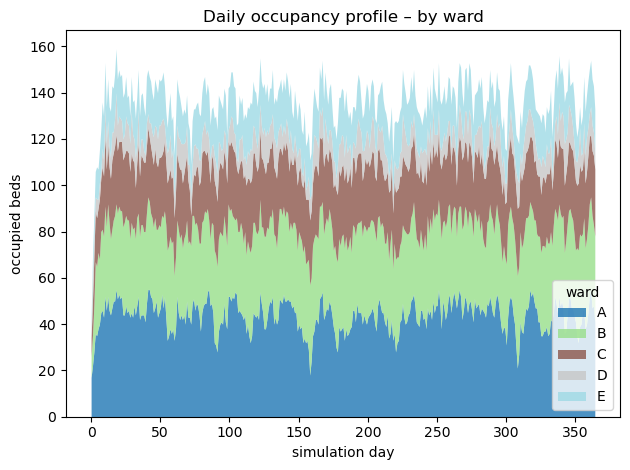

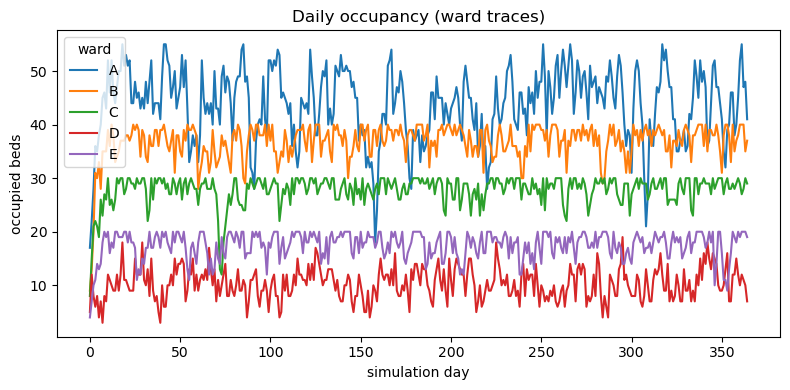


Occupancy summary (beds):
| ward   |   mean |   min |   25% |   50% |   75% |   max |
|:-------|-------:|------:|------:|------:|------:|------:|
| A      |   43.8 |  17.0 |  40.0 |  45.0 |  49.0 |  55.0 |
| B      |   36.8 |   9.0 |  35.0 |  38.0 |  39.0 |  40.0 |
| C      |   27.8 |   8.0 |  27.0 |  29.0 |  30.0 |  30.0 |
| D      |   10.3 |   3.0 |   8.0 |  10.0 |  12.0 |  19.0 |
| E      |   17.5 |   4.0 |  16.0 |  18.0 |  20.0 |  20.0 |


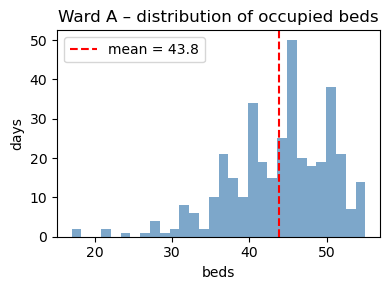

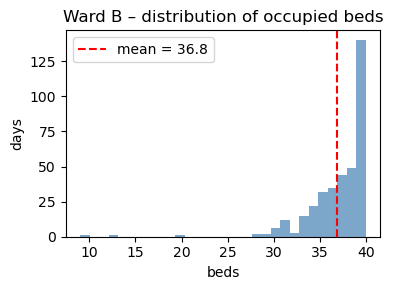

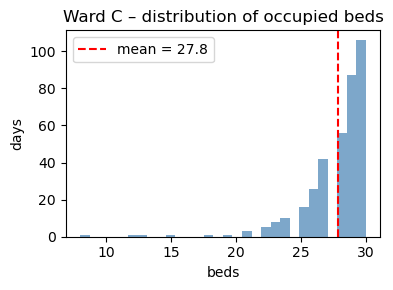

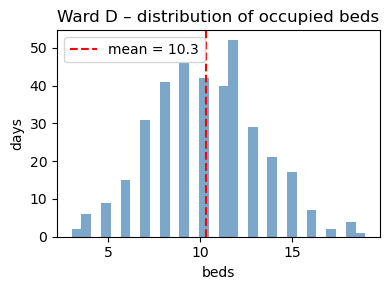

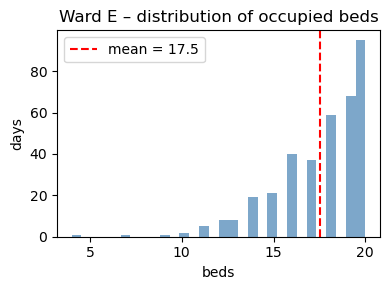

In [3]:
# -------------------------------------------------
#  Occupancy time-series  (needs occupancy_log)
# -------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# turn raw list -> tidy DataFrame
df = (pd.DataFrame(occupancy_log, columns=["time", "ward", "delta"])
        .sort_values("time"))

# cumulative occupancy for every ward
df["day"] = df["time"].astype(int)          # floor-to-day
cum = (df.pivot_table(index="day", columns="ward", values="delta",
                      aggfunc="sum", fill_value=0)
         .cumsum())                         # running total per ward

# make sure we have a row for *every* day 0…364
cum = cum.reindex(range(365), fill_value=np.nan).ffill().fillna(0)

# 1) Stacked-area plot ⇢ snapshot of hospital load ---------------------------
plt.figure(figsize=(8,4))
cum.plot.area(colormap="tab20", alpha=.8, linewidth=0)
plt.xlabel("simulation day")
plt.ylabel("occupied beds")
plt.title("Daily occupancy profile – by ward")
plt.tight_layout()
plt.show()

# 2) Simple per-ward line plot -----------------------------------------------
cum.plot(figsize=(8,4))
plt.xlabel("simulation day")
plt.ylabel("occupied beds")
plt.title("Daily occupancy (ward traces)")
plt.tight_layout()
plt.show()

# 3)  Summary statistics ------------------------------------------------------
stats = cum.describe(percentiles=[.01, .25, .5, .75, .99]).T
stats = stats[["mean", "min", "25%", "50%", "75%", "max"]]
print("\nOccupancy summary (beds):")
print(stats.to_markdown(floatfmt=".1f"))

# 4)  Histogram of occupancy per ward ----------------------------------------
for ward in cum.columns:
    plt.figure(figsize=(4,3))
    plt.hist(cum[ward], bins=30, color="steelblue", alpha=.7)
    plt.axvline(cum[ward].mean(), color="red", linestyle="--",
                label=f"mean = {cum[ward].mean():.1f}")
    plt.title(f"Ward {ward} – distribution of occupied beds")
    plt.xlabel("beds")
    plt.ylabel("days")
    plt.legend()
    plt.tight_layout()
    plt.show()